#### Import packages and device selection

In [1]:
import gc
import os
import re
import cv2
from tqdm.notebook import tqdm
import optuna
from optuna.trial import TrialState
import torch
from torch import nn, optim
from torch.utils.checkpoint import checkpoint
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torchvision.models as models
from torchinfo import summary
from sklearn.model_selection import KFold, train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SIZE = 224
seed = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(seed)
torch.manual_seed(seed) # if using CPU
torch.cuda.manual_seed(seed) # if using single-GPU
torch.cuda.manual_seed_all(seed) # if using multi-GPU
torch.backends.cudnn.deterministic = True # deterministic mode
torch.backends.cudnn.benchmark = False # disable auto-tuner to find the best algorithm to use for your hardware
torch.backends.cuda.matmul.allow_tf32 = True # allow TensorFloat-32 on matmul operations
torch.backends.cudnn.allow_tf32  = True # allow TensorFloat-32 on convolution operations
torch.autograd.set_detect_anomaly(True)

In [3]:
print("Using device: ", device)

Using device:  cuda


## Dataset Loading and Preprocessing

#### This is used only to visualize some samples from the dataset

In [ ]:
def sort_files(folder):
    convert_func = lambda x: int(x) if x.isdigit() else x.lower()
    key_func = lambda x: [convert_func(c) for c in re.split('([0-9]+)', x)]
    return sorted(folder, key=key_func)

input_L = []
target_ab = []
path = '../data/color'
folder = os.listdir(path)
folder = sort_files(folder)
for file in tqdm(folder, desc='Loading color images'):
    img = cv2.imread(os.path.join(path, file), 1)
    img = img.astype(np.float32) / 255.0 # [0..1]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    img = cv2.resize(img, (SIZE, SIZE))
    L = img[:, :, 0:1] # (H, W, 1) [0..100]
    ab = img[:, :, 1:3] # (H, W, 2) [-128..127]
    input_L.append(L)
    target_ab.append(ab)
input_L = np.array(input_L) # (N, H, W, 1)
target_ab = np.array(target_ab) # (N, H, W, 2

Loading color images:   0%|          | 0/7129 [00:00<?, ?it/s]

In [5]:
print(input_L.shape, target_ab.shape)

(7129, 224, 224, 1) (7129, 224, 224, 2)


#### Display some samples

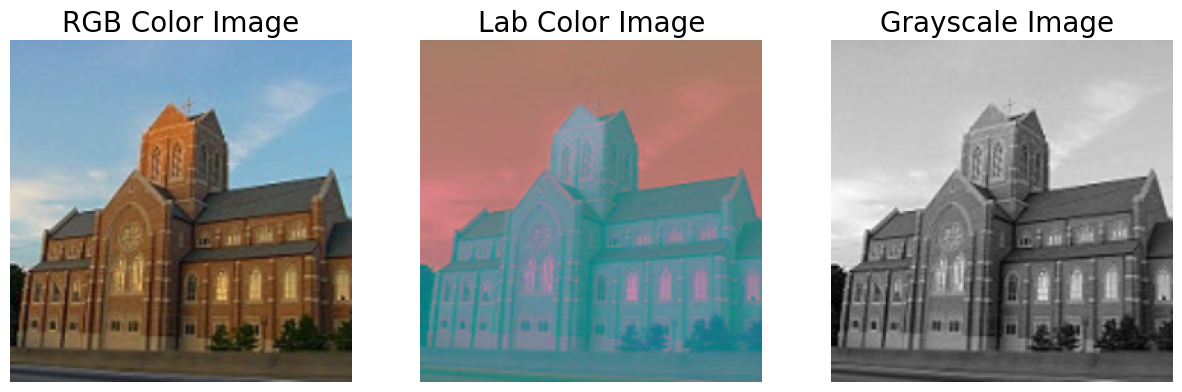

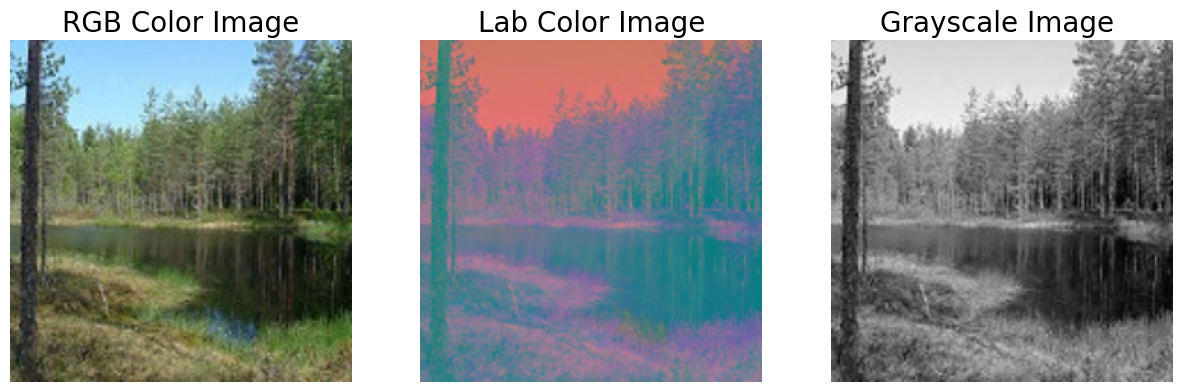

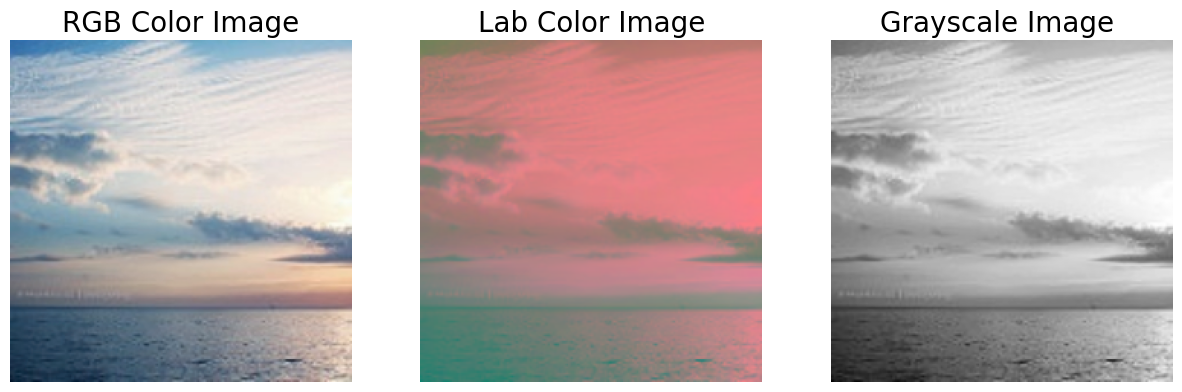

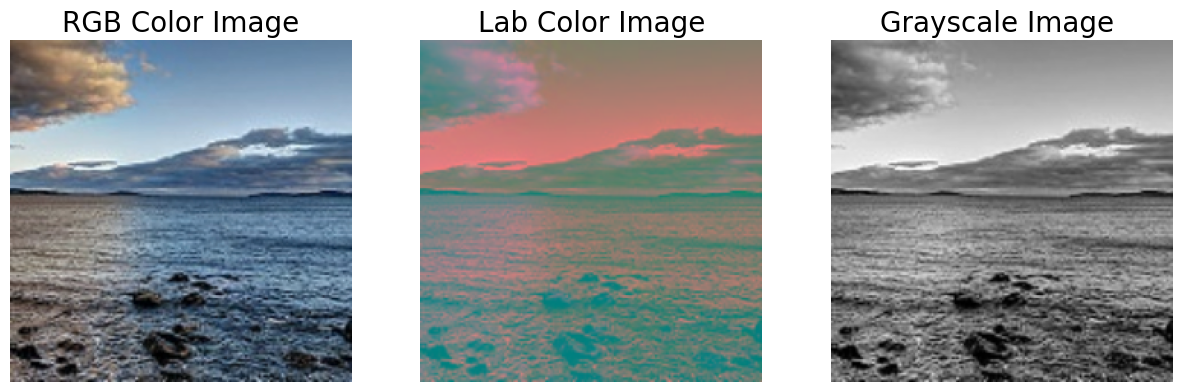

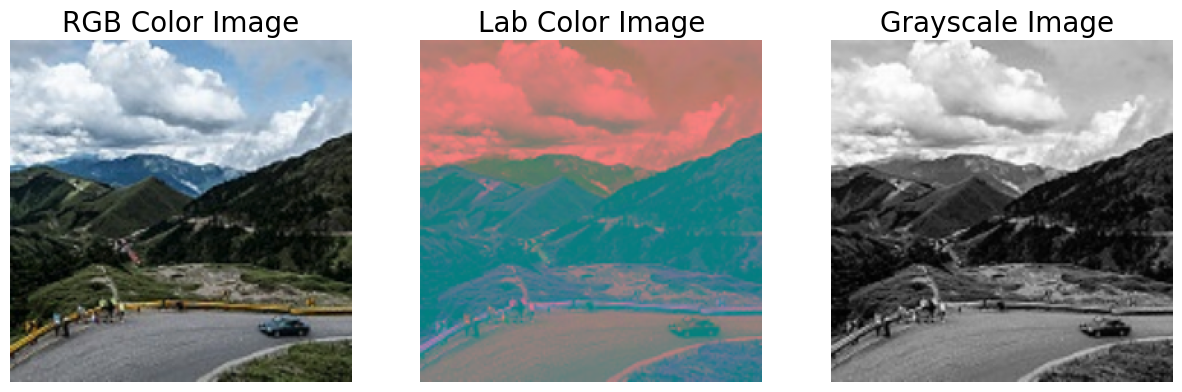

In [6]:
for _ in range(5):
    idx = np.random.randint(0, len(input_L) - 1)
    color_img = np.concatenate([input_L[idx] / 100 * 255, target_ab[idx] + 128], axis=2).clip(0, 255).astype(np.uint8)
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('RGB Color Image', fontsize=20)
    plt.imshow(np.clip(cv2.cvtColor(color_img, cv2.COLOR_LAB2RGB), 0, 255))
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Lab Color Image', fontsize=20)
    plt.imshow(color_img)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Grayscale Image ', fontsize=20)
    plt.imshow((input_L[idx] / 100 * 255).astype(np.uint8).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

#### Split into training and test data

We can use the entire dataset, instead of the file path, as it is small enough to fit in memory

In [7]:
input_L = (torch.from_numpy(input_L) / 100.0).permute(0, 3, 1, 2) # (N, 1, H, W) [0..1]
target_ab = torch.from_numpy(target_ab).permute(0, 3, 1, 2) # (N, 2, H, W) [-128..127]
L_train, L_test, ab_train, ab_test = train_test_split(input_L, target_ab, test_size=0.2, random_state=seed)
L_val, L_test, ab_val, ab_test = train_test_split(L_test, ab_test, test_size=0.2, random_state=seed)

In [8]:
print(L_train.shape, ab_train.shape)
print(L_val.shape, ab_val.shape)
print(L_test.shape, ab_test.shape)

torch.Size([5703, 1, 224, 224]) torch.Size([5703, 2, 224, 224])
torch.Size([1140, 1, 224, 224]) torch.Size([1140, 2, 224, 224])
torch.Size([286, 1, 224, 224]) torch.Size([286, 2, 224, 224])


In [9]:
L_mean = torch.mean(L_train, dim=[0, 2, 3])
L_std = torch.std(L_train, dim=[0, 2, 3])

In [10]:
print(L_mean, L_std)

tensor([0.4731]) tensor([0.2583])


In [11]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, L_data, ab_data, L_transform=None):
        self.L_data = L_transform(L_data) if L_transform else L_data
        self.ab_data = ab_data

    def __len__(self):
        return len(self.L_data)

    def __getitem__(self, idx):
        return self.L_data[idx], self.ab_data[idx]

In [12]:
class CUDAPrefetcher:
    def __init__(self, loader):
        self.loader = iter(loader)
        self.stream = torch.cuda.Stream()
        self.next_L = None
        self.next_ab = None
        self._preload()

    def _preload(self):
        try:
            self.next_L, self.next_ab = next(self.loader)
        except StopIteration:
            self.next_L = None
            return
        with torch.cuda.stream(self.stream):
            self.next_L = self.next_L.to(device, memory_format=torch.channels_last, non_blocking=True)
            self.next_ab = self.next_ab.to(device, non_blocking=True)

    def next(self):
        torch.cuda.current_stream().wait_stream(self.stream)
        L, ab = self.next_L, self.next_ab
        self._preload()
        return L, ab

In [13]:
trainset = MyDataset(L_train, ab_train, L_transform=transforms.Normalize(mean=L_mean, std=L_std))
valset = MyDataset(L_val, ab_val, L_transform=transforms.Normalize(mean=L_mean, std=L_std))
testset = MyDataset(L_test, ab_test, L_transform=transforms.Normalize(mean=L_mean, std=L_std))
del L_train, ab_train, L_val, ab_val, L_test, ab_test

## Training pipeline

#### Early stopping used to stop training if model begins to overfit

In [14]:
def save_checkpoint(model, name='checkpoint'):
    torch.save(model.state_dict(), f"../models/{name}.pth")

class EarlyStopping:
    def __init__(self, patience=10, delta=0.05):
        self.patience = patience
        self.counter = 0
        self.best_score = np.Inf
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, net):
        if self.best_score > val_loss:
            self.best_score = val_loss
            self.counter = 0
            save_checkpoint(net)
        elif self.best_score + self.delta < val_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

#### Check VGG19 architecture to select layers for perceptual loss

In [15]:
# print(models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features)

In [16]:
class VGGLoss(nn.Module):
    def __init__(self, layers):
        super(VGGLoss, self).__init__()
        blocks = []
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features
        for i in range(len(layers)-1):
            blocks.append(nn.Sequential(*list(vgg.children())[layers[i]:layers[i+1]]))
        self.blocks = nn.ModuleList(blocks)
        for block in self.blocks:
            block.eval()
            for p in block.parameters():
                p.requires_grad = False
        self.blocks = nn.ModuleList(blocks)
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1))

    def _lab_to_rgb(self, L, ab):
        lab = torch.cat([L, ab], dim=1)  # (B,3,H,W)
        # convert to XYZ
        Y = (lab[:, 0:1, :, :] + 16.0) / 116.0
        X = lab[:, 1:2, :, :] / 500.0 + Y
        Z = Y - lab[:, 2:3, :, :] / 200.0
        # apply f^-1 (piecewise)
        eps = 0.008856
        Y = torch.where(Y > eps, Y ** 3, (Y - 16.0 / 116.0) / 7.787)
        X = torch.where(X > eps, X ** 3, (X - 16.0 / 116.0) / 7.787)
        Z = torch.where(Z > eps, Z ** 3, (Z - 16.0 / 116.0) / 7.787)
        xyz = torch.cat([X, Y, Z], dim=1)
        # Apply D65 whitepoint scaling
        xyz = xyz.clone()
        xyz[:, 0:1, :, :] = xyz[:, 0:1, :, :] * 0.95047
        xyz[:, 2:3, :, :] = xyz[:, 2:3, :, :] * 1.08883
        rgb = torch.zeros_like(xyz)
        rgb[:, 0:1, :, :] = (3.2404542 * xyz[:, 0:1, :, :] -
                             1.5371385 * xyz[:, 1:2, :, :] -
                             0.4985314 * xyz[:, 2:3, :, :])
        rgb[:, 1:2, :, :] = (-0.9692660 * xyz[:, 0:1, :, :] +
                             1.8760108 * xyz[:, 1:2, :, :] +
                             0.0415560 * xyz[:, 2:3, :, :])
        rgb[:, 2:3, :, :] = (0.0556434 * xyz[:, 0:1, :, :] -
                             0.2040259 * xyz[:, 1:2, :, :] +
                             1.0572252 * xyz[:, 2:3, :, :])
        # gamma correction
        # sanitize NaN/inf first (replace with numeric safe values)
        rgb_sane = torch.nan_to_num(rgb, nan=0.0, posinf=1e6, neginf=0.0)
        # clamp negative values to avoid NaN in pow
        rgb_for_pow = torch.clamp(rgb_sane, min=1e-10)
        rgb_pow = rgb_for_pow ** (1.0 / 2.4)
        # threshold mask (still uses original rgb for linear branch to preserve negatives)
        mask = rgb_sane > 0.0031308
        rgb = torch.where(mask, 1.055 * rgb_pow - 0.055, 12.92 * rgb_sane)
        rgb = torch.clamp(rgb, 0.0, 1.0)
        return rgb


    def forward(self, L, ab_pred, ab_target):
        L = L * 100.0
        pred_rgb = (self._lab_to_rgb(L, ab_pred) - self.mean) / self.std
        target_rgb = (self._lab_to_rgb(L, ab_target) - self.mean) / self.std
        loss = torch.tensor(0.0, device=device)
        x = pred_rgb
        y = target_rgb
        for block in self.blocks:
            x = block(x)
            y = block(y)
            loss += nn.functional.l1_loss(x, y)
        return loss

def fit(net, trainloader, optimizer, scaler, loss_pixel_fn, loss_vgg_fn, coeff_vgg, coeff_kld):
    total_loss, total_sse, pixels, count = torch.tensor(0.0, device=device), torch.tensor(0.0, device=device), 0, 0
    net.train()
    prefetcher = CUDAPrefetcher(trainloader)
    inputs, targets = prefetcher.next()
    while inputs is not None:
        with torch.cuda.amp.autocast():
            out, mu, logvar = net(inputs)
            out = (out + 1.0) / 2.0 * 255.0 - 128.0  # rescale to [-128, 127]
            loss_rec = loss_pixel_fn(out, targets)
            if coeff_vgg > 0.0:
                loss_rec += coeff_vgg * loss_vgg_fn(inputs, out, targets)
            loss_kld = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim=1).mean()
            loss = loss_rec + coeff_kld * loss_kld
        optimizer.zero_grad(set_to_none=True)
        if not torch.isfinite(loss):
            inputs, targets = prefetcher.next()
            continue
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(net.parameters(), 2)
        scaler.step(optimizer)
        scaler.update()
        with torch.no_grad():
            total_loss += loss_rec.detach()
            count += 1
            sse = nn.MSELoss(reduction='sum')(out, targets)
            total_sse += sse
            pixels += targets.numel()
        inputs, targets = prefetcher.next()
    mse = total_sse / pixels
    rmse = torch.sqrt(mse)
    eps = 1e-10
    psnr = 10 * torch.log10((255.0 ** 2) / (mse + eps))
    return (total_loss / count).item(), rmse.item(), psnr.item()

@torch.inference_mode()
def predict(net, valloader, loss_pixel_fn, loss_vgg_fn, coeff_vgg):
    total_loss, total_sse, pixels, count = torch.tensor(0.0, device=device), torch.tensor(0.0, device=device), 0, 0
    net.eval()
    prefetcher = CUDAPrefetcher(valloader)
    inputs, targets = prefetcher.next()
    while inputs is not None:
        with torch.cuda.amp.autocast():
            out, mu, logvar = net(inputs)
            out = (out + 1.0) / 2.0 * 255.0 - 128.0  # rescale to [-128, 127]
            loss_rec = loss_pixel_fn(out, targets)
            if coeff_vgg > 0.0:
                loss_rec += coeff_vgg * loss_vgg_fn(inputs, out, targets)
        total_loss += loss_rec.detach()
        count += 1
        sse = nn.MSELoss(reduction='sum')(out, targets)
        total_sse += sse
        pixels += targets.numel()
        inputs, targets = prefetcher.next()
    mse = total_sse / pixels
    rmse = torch.sqrt(mse)
    eps = 1e-10
    psnr = 10 * torch.log10((255.0 ** 2) / (mse + eps))
    return (total_loss / count).item(), rmse.item(), psnr.item()

#### Objective method for k fold cross validation

In [17]:
def objective(trial, trainset, scaler, X):
    num_cycles = trial.suggest_int('num_cycles', 4, 10)
    cycle_length = num_epochs // num_cycles
    final_beta = 0.5
    gamma = trial.suggest_float('gamma', 0.1, 1.0)
    layers = trial.suggest_categorical('layers', [[0, 17], [0, 17, 26]])
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    latent_dim = trial.suggest_categorical('latent_dim', [64, 128, 256, 512])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    val_losses, mean_loss = [], 0.0
    split_n = 0
    prog_bar = tqdm(kf.split(X), desc="Splits", position=0)
    for train_idx, val_idx in prog_bar:
        split_n += 1
        trainloader = DataLoader(trainset, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx), num_workers=4, pin_memory=True, prefetch_factor=2)
        valloader = DataLoader(trainset, batch_size=batch_size, sampler=SubsetRandomSampler(val_idx), num_workers=4, pin_memory=True, prefetch_factor=2)
        criterion1 = nn.MSELoss(reduction='mean').to(device)
        criterion2 = VGGLoss(layers).to(device)
        net = Net(latent_dim).to(device, memory_format=torch.channels_last)
        optimizer = optim.AdamW(net.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        for epoch in range(50):
            cycle_pos = epoch % cycle_length
            beta = final_beta * (0.5 * (1 + np.cos(np.pi * (1 - cycle_pos / cycle_length))))
            train_loss, train_rmse, train_psnr = fit(net, trainloader, optimizer, scaler, criterion1, criterion2, gamma, beta)
            val_loss, val_rmse, val_psnr = predict(net, valloader, criterion1, criterion2, gamma)
            val_losses.append(val_loss)
            scheduler.step(val_loss)
            prog_bar.set_description(f"Epoch {epoch + 1}, lr={current_lr}, beta={beta:.3f}, Loss={train_loss:.3f}/{val_loss:.3f} | "
                                     f"Metrics train/val: RMSE={train_rmse:.3f}/{val_rmse:.3f}, PSNR={train_psnr:.3f}/{val_psnr:.3f}")
        del net, optimizer, scheduler
        mean_loss = np.mean(val_losses)
        trial.report(mean_loss, split_n)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return mean_loss

#### CAE NN definition

out = (in - kernel + 2 * pad) / stride + 1

In [18]:
class Net(nn.Module):
    def __init__(self, latent_dim=256):
        super(Net, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_mu_logvar = nn.Conv2d(256, 2 * latent_dim, kernel_size=1)
        self.decoder_input = nn.Linear(latent_dim, 256 * SIZE // 8 * SIZE // 8)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, SIZE // 8, SIZE // 8)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x) # [B, 256, 28, 28]
        pooled = self.pool(encoded) # [B, 256, 1, 1]
        mu_logvar = self.fc_mu_logvar(pooled).squeeze(-1).squeeze(-1) # [B, 2 * latent_dim]
        mu, logvar = mu_logvar.chunk(2, dim=1)
        z = self.reparameterize(mu, logvar)
        decoder_input = self.decoder_input(z)
        x = self.decoder(decoder_input)
        return x, mu, logvar

In [19]:
writer = SummaryWriter('../runs')
net = Net().eval()
# torch.quantization.fuse_modules(net, [
#     ['conv3', 'bnorm1'],
#     ['conv4', 'bnorm2'],
#     ['conv5', 'bnorm3']
# ], inplace=True)
net = net.to(device, memory_format=torch.channels_last)
for m in net.modules():
    if isinstance(m, (torch.nn.Conv2d, torch.nn.ConvTranspose2d)):
        m.weight = torch.nn.Parameter(m.weight.to(memory_format=torch.channels_last))
dummy = torch.zeros(1, 1, SIZE, SIZE).to(device, memory_format=torch.channels_last)
writer.add_graph(net, dummy)
writer.flush()
summary(net, input_data=dummy, col_names=('input_size', 'output_size', 'num_params', 'trainable'))

/home/vito/miniconda3/envs/pyatom/lib/python3.11/site-packages/torch/jit/_trace.py:1116: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps : Float(1, 256, strides=[256, 1], requires_grad=0, device=cuda:0) = aten::randn_like(%std, %345, %346, %347, %348, %349) # /tmp/ipykernel_347204/3543769071.py:42:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  _check_trace(
/home/vito/miniconda3/envs/pyatom/lib/python3.11/site-packages/torch/jit/_trace.py:1116: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 100194 / 100352 (99.8%)
Greatest absolute difference: 0.04509945446625352 at index (0, 0, 15, 33) (up to 1e-05 allowed)
Greatest relative difference: 2931.49404489235 at index (0, 0, 103, 169) (up to 1e-05 allowed)
  _check_trace(


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Net                                      [1, 1, 224, 224]          [1, 2, 224, 224]          --                        True
├─Sequential: 1-1                        [1, 1, 224, 224]          [1, 256, 28, 28]          --                        True
│    └─Conv2d: 2-1                       [1, 1, 224, 224]          [1, 64, 112, 112]         640                       True
│    └─LeakyReLU: 2-2                    [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --
│    └─Conv2d: 2-3                       [1, 64, 112, 112]         [1, 128, 112, 112]        73,856                    True
│    └─LeakyReLU: 2-4                    [1, 128, 112, 112]        [1, 128, 112, 112]        --                        --
│    └─Conv2d: 2-5                       [1, 128, 112, 112]        [1, 128, 56, 56]          147,584                   True
│    └─

Run command:\
tensorboard --logdir=runs\
Visible at http://localhost:6006/

#### Unit test: graident flow check

In [20]:
def test_grad_flow(test_net):
    test_net.train()
    inputs = torch.rand(4, 1, SIZE, SIZE, device=device, dtype=torch.float32, requires_grad=False)
    targets = (torch.rand(4, 2, SIZE, SIZE, device=device) * 255.0) - 128.0
    optimizer = optim.AdamW(test_net.parameters(), lr=1e-4)
    criterion1 = nn.L1Loss(reduction='mean').to(device)
    criterion2 = VGGLoss([0,17,26]).to(device)
    out, mu, logvar = test_net(inputs)
    out_rescaled = (out + 1.0) / 2.0 * 255.0 - 128.0  # rescale to [-128, 127]
    loss_pix = criterion1(out_rescaled, targets)
    print(f"Pixel loss: {loss_pix.item():.4f}")
    loss_vgg = criterion2(inputs, out_rescaled, targets) * 0.5
    print(f"VGG loss: {loss_vgg.item():.4f}")
    loss_kld = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim=1).mean() * 0.1
    print(f"KLD loss: {loss_kld.item():.4f}")
    loss = loss_pix + loss_vgg + loss_kld
    print(f"Total loss: {loss.item():.4f}")
    optimizer.zero_grad()
    loss.backward()
    net_has_grad = False
    for p in test_net.parameters():
        if p.grad is not None:
            if float(p.grad.abs().sum()) > 0.0:
                net_has_grad = True
                break
    vgg_params_ok = True
    for name, p in criterion2.named_parameters():
        if p.requires_grad:
            print(f"VGGLoss parameter {name} has requires_grad=True (should be False).")
            vgg_params_ok = False
        if p.grad is not None:
            # Ideally grads are None for frozen params
            print(f"VGGLoss parameter {name} has non-None grad (should be None).")
            vgg_params_ok = False
    print(f"Net received gradient? {net_has_grad}")
    print(f"VGGLoss params frozen and no grads? {vgg_params_ok}")
    return net_has_grad, vgg_params_ok

test_net = Net().to(device, memory_format=torch.channels_last)
ok_net, ok_vgg = test_grad_flow(test_net)
assert ok_net and ok_vgg, "Unit test failed: check gradients or VGGLoss freezing"

Pixel loss: 65.1619
VGG loss: 5.6424
KLD loss: 0.0251
Total loss: 70.8294
Net received gradient? True
VGGLoss params frozen and no grads? True


#### Hyper parameter tuning

In [21]:
# del dummy
# gc.collect()
# torch.cuda.empty_cache()
# X = np.zeros(len(trainset))
# torch.cuda.empty_cache()
# scaler = torch.cuda.amp.GradScaler()
# study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
# study.optimize(lambda trial: objective(trial, trainset, scaler, X), n_trials=5)

In [22]:
# pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
# complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
#
# print("Study statistics: ")
# print("  Number of finished trials: ", len(study.trials))
# print("  Number of pruned trials: ", len(pruned_trials))
# print("  Number of complete trials: ", len(complete_trials))
#
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

#### Entire dataset

In [23]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=2)
valloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)
optimizer = optim.AdamW(net.parameters(), lr=1e-4, fused=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
criterion1 = nn.L1Loss(reduction='mean').to(device)
criterion2 = VGGLoss([0,17,26]).to(device)
del dummy # , prior
early_stopping = EarlyStopping()
train_losses, train_rmses, train_psnrs, train_pccs = [], [], [], []
val_losses, val_rmses, val_psnrs, val_pccs = [], [], [], []
last_checkpoint = None
num_epochs = 50
num_cycles = 4
cycle_length = num_epochs // num_cycles
final_coeff_kld = 0.5
coeff_vgg = 0.5

In [24]:
gc.collect()
torch.cuda.empty_cache()

Only for testing botttlenecks

In [25]:
# import torch.autograd.profiler as prof
#
# scaler = torch.cuda.amp.GradScaler()
# with prof.profile(record_shapes=True, use_cuda=True) as p:
#     with prof.record_function("train_step"):
#         _, *_ = fit(net, trainloader, optimizer, scaler, criterion)
# print(p.key_averages().table(sort_by="cuda_time_total", row_limit=10))

In [26]:
%matplotlib notebook
def update_plot():
    line1.set_data(range(len(train_losses)), train_losses)
    line2.set_data(range(len(val_losses)), val_losses)
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw()

In [27]:
prog_bar = tqdm(range(num_epochs), total=num_epochs, desc='Training', position=0)

fig, ax = plt.subplots()
line1, = ax.plot([], [], label='Train Loss')
line2, = ax.plot([], [], label='Val Loss')
ax.legend()

scaler = torch.cuda.amp.GradScaler()
for epoch in prog_bar:
    cycle_pos = epoch % cycle_length
    coeff_kld = final_coeff_kld * (0.5 * (1 + np.cos(np.pi * (1 - cycle_pos / cycle_length))))
    train_loss, train_rmse, train_psnr = fit(net, trainloader, optimizer, scaler, criterion1, criterion2, coeff_vgg, coeff_kld)
    train_losses.append(train_loss)
    train_rmses.append(train_rmse)
    train_psnrs.append(train_psnr)
    val_loss, val_rmse, val_psnr = predict(net, valloader, criterion1, criterion2, coeff_vgg)
    val_losses.append(val_loss)
    val_rmses.append(val_rmse)
    val_psnrs.append(val_psnr)
    #scheduler.step(val_img_acc)
    #early_stopping(val_loss, net)
    current_lr = optimizer.param_groups[0]['lr']
    prog_bar.set_description(f"Epoch {epoch + 1}, lr={current_lr}, coeff_kld={coeff_kld:.3f}, Loss={train_loss:.3f}/{val_loss:.3f} | "
                             f"Metrics train/val: RMSE={train_rmse:.3f}/{val_rmse:.3f}, PSNR={train_psnr:.3f}/{val_psnr:.3f}")
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    update_plot()
    # if early_stopping.early_stop:
    #     print("Early stopping")
    #     break
save_checkpoint(net, 'lastcheck')
writer.flush()

Training:   0%|          | 0/50 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [28]:
%matplotlib inline
class ModelWithLoss(nn.Module):
    def __init__(self, net, loss_fn):
        super().__init__()
        self.net = net
        self.loss_fn = loss_fn

    def forward(self, x, y):
        preds = self.net(x)
        return self.loss_fn(preds, y)

## Evaluate results

To use NN:
rt = torch.jit.load("model_and_loss.pt")\
rt.eval()\
out = rt(input_tensor, target_tensor)

In [29]:
@torch.inference_mode()
def final_predict(net, valloader):
    net.eval()
    ins, preds, truths = [], [], []
    prefetcher = CUDAPrefetcher(valloader)
    inputs, targets = prefetcher.next()
    prog_bar = tqdm(total=len(valloader), desc='Final Predicting', leave=False)
    while inputs is not None:
        with torch.cuda.amp.autocast():
            out, *_ = net(inputs)
            out = (out + 1.0) / 2.0 * 255.0 - 128.0  # rescale to [-128, 127]
        ins.append(inputs.cpu())
        preds.append(out.cpu())
        truths.append(targets.cpu())
        inputs, targets = prefetcher.next()
        prog_bar.update(1)
    prog_bar.close()
    return ins, preds, truths

In [30]:
gc.collect()
torch.cuda.empty_cache()

In [31]:
# net.load_state_dict(torch.load('../models/checkpoint.pth'))
ins, preds, truths = final_predict(net, testloader)
# net_script = ModelWithLoss(net, nn.MSELoss(reduction='mean'))
# # net_script = ModelWithLoss(net, nn.CrossEntropyLoss(weight=weights, reduction='mean'))
# net_script = torch.jit.script(net_script)
# net_script.save('../models/model_and_loss.pt')

Final Predicting:   0%|          | 0/5 [00:00<?, ?it/s]

In [32]:
ins = (torch.cat(ins, 0) * L_std.reshape(1, -1, 1, 1) + L_mean.reshape(1, -1, 1, 1)) * 100.0 # unstandardize and rescale to [0..100]
preds_rgb = (torch.cat([ins, torch.cat(preds, 0)], 1)
             .permute(0, 2, 3, 1).detach().cpu().numpy()) # (N, H, W, 3)
preds_rgb = [cv2.cvtColor(img, cv2.COLOR_LAB2RGB) for img in preds_rgb]
truths_rgb = (torch.cat([ins, torch.cat(truths, 0)], 1)
             .permute(0, 2, 3, 1).detach().cpu().numpy()) # (N, H, W, 3)
truths_rgb = [cv2.cvtColor(img, cv2.COLOR_LAB2RGB) for img in truths_rgb]
ins = ins.permute(0, 2, 3, 1).detach().cpu().numpy() # (N, H, W, 1)

In [33]:
gc.collect()
torch.cuda.empty_cache()

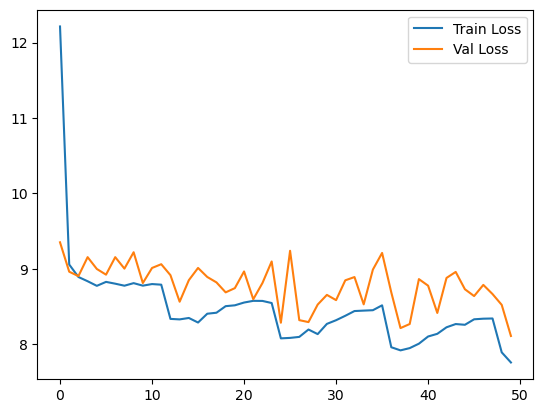

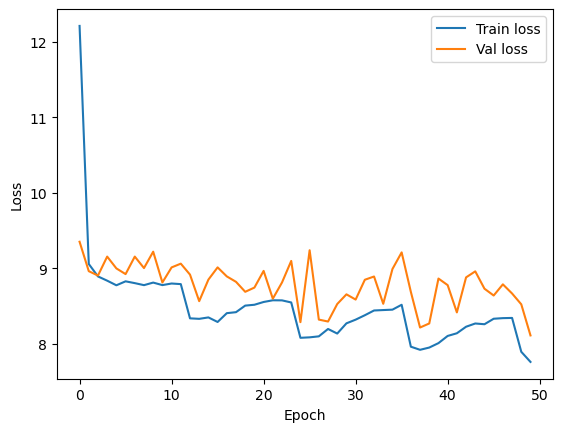

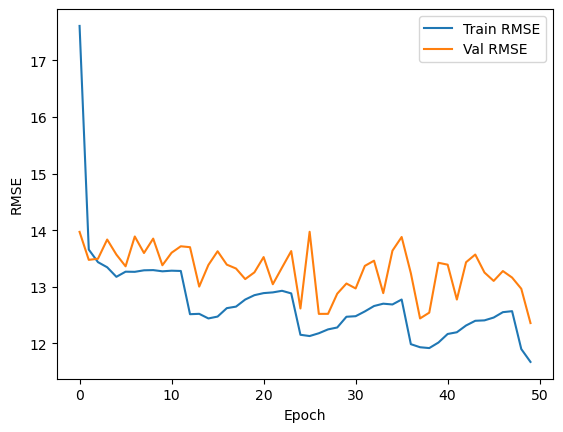

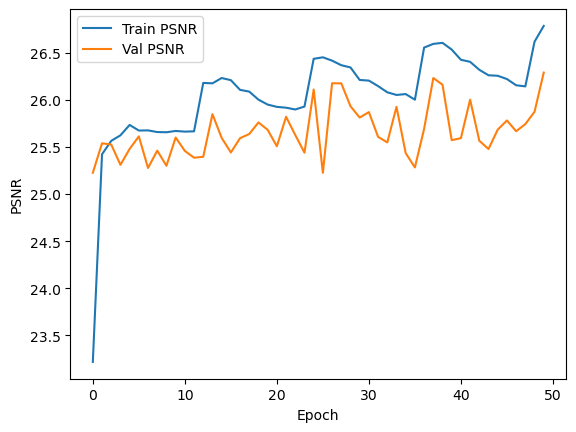

In [34]:
plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_rmses, label='Train RMSE')
plt.plot(val_rmses, label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_psnrs, label='Train PSNR')
plt.plot(val_psnrs, label='Val PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()
plt.show()

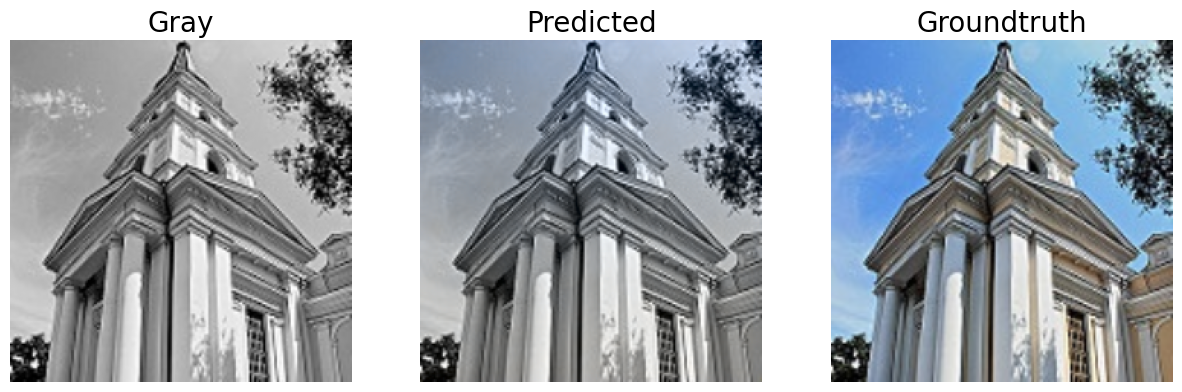

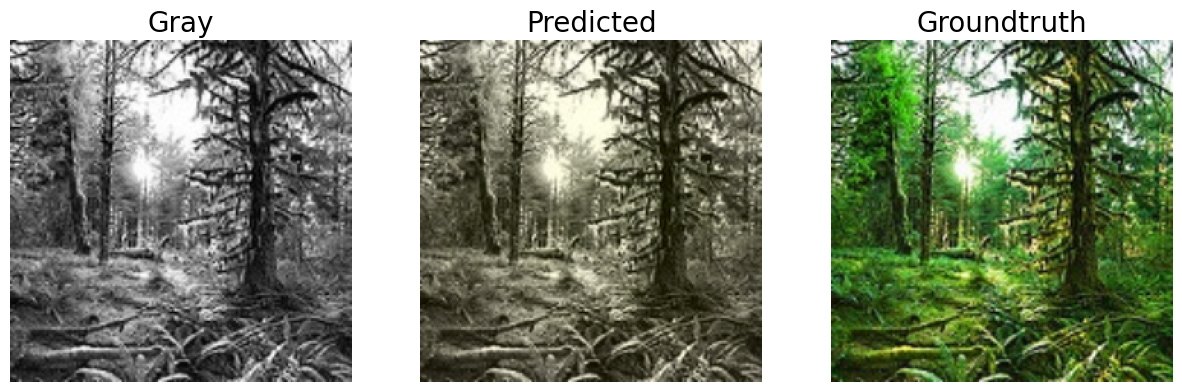

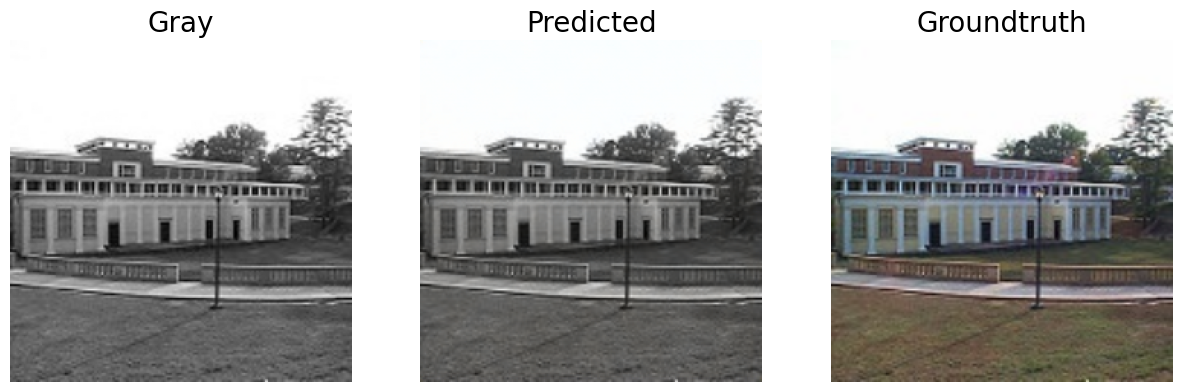

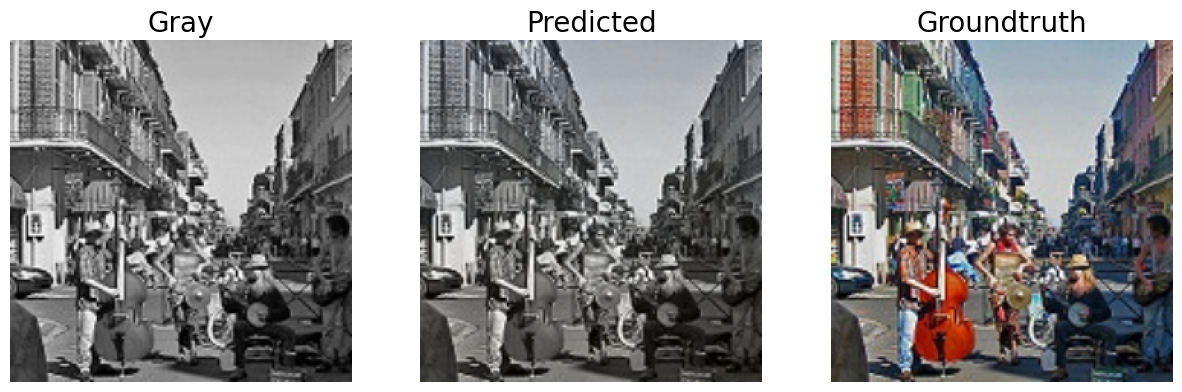

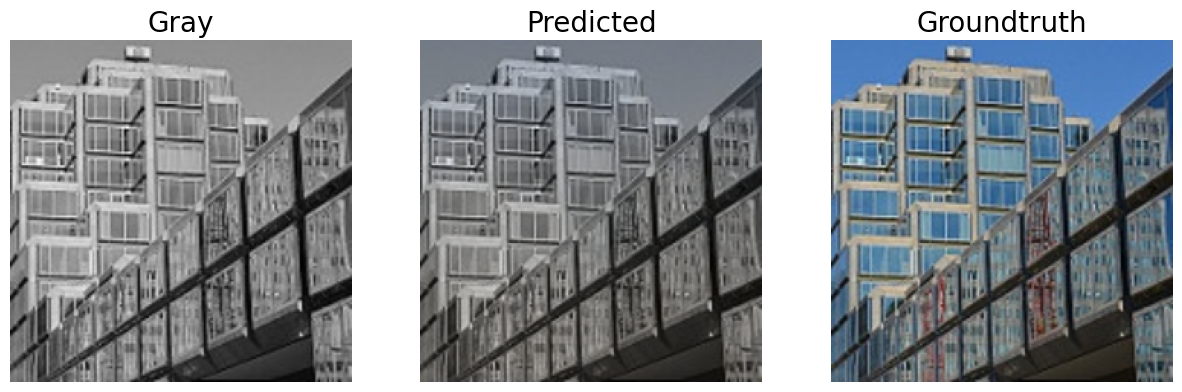

In [35]:
for _ in range(5):
    idx = np.random.randint(0, len(ins))
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('Gray', fontsize=20)
    plt.imshow(ins[idx] , cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Predicted', fontsize=20)
    plt.imshow(preds_rgb[idx])
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Groundtruth', fontsize=20)
    plt.imshow(truths_rgb[idx])
    plt.axis('off')
    plt.show()